
#  Transformer Model for Chat Summarization Using TensorFlow

In this Notebook we will explore summarization using the transformer model. We will  implement the full transformer (both encoder and decoder)


<a name='0'></a>
## Introduction

Summarization is an important task in natural language processing and could be useful for a consumer enterprise. For example, bots can be used to scrape articles, summarize them, and then you can use sentiment analysis to identify the sentiment about certain stocks. Who wants to read an article or a long email today anyway, In this notebookwill learn to:  

- Use built-in functions to preprocess your data
- Implement DotProductAttention
- Implement Causal Attention
- Understand how attention works
- Build the transformer model
- Evaluate your model
- Summarize an article


In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import re

import textwrap
wrapper = textwrap.TextWrapper(width=70)

tf.keras.utils.set_random_seed(10)


## 1 - Import the Dataset


In [6]:


def get_train_test_data(data_dir):
    # Get the train data
    train_data = pd.read_json(f"{data_dir}/train.json")
    train_data.drop(['id'], axis=1, inplace=True)

    # Get the test data
    test_data = pd.read_json(f"{data_dir}/test.json")
    test_data.drop(['id'], axis=1, inplace=True)

    return train_data, test_data



In [7]:
data_dir = "/content/"

train_data, test_data = get_train_test_data(data_dir)

# Take one example from the dataset and print it
example_summary, example_dialogue = train_data.iloc[10]
print(f"Dialogue:\n{example_dialogue}")
print(f"\nSummary:\n{example_summary}")

Dialogue:
Lucas: Hey! How was your day?
Demi: Hey there! 
Demi: It was pretty fine, actually, thank you!
Demi: I just got promoted! :D
Lucas: Whoa! Great news!
Lucas: Congratulations!
Lucas: Such a success has to be celebrated.
Demi: I agree! :D
Demi: Tonight at Death & Co.?
Lucas: Sure!
Lucas: See you there at 10pm?
Demi: Yeah! See you there! :D

Summary:
Demi got promoted. She will celebrate that with Lucas at Death & Co at 10 pm.



## 2 - Preprocess the data

First we will do some preprocessing of the data and split it into inputs and outputs. Here we also remove some of the characters that are specific to this dataset and add the `[EOS]` (end of sentence) token to the end. We will also add a `[SOS]` (start of sentence) token to the beginning of the sentences.

In [8]:

def preprocess(input_data):
    # Define the custom preprocessing function
    def preprocess_util(input_data):
        # Convert all text to lowercase
        lowercase = input_data.lower()
        # Remove newlines and double spaces
        removed_newlines = re.sub("\n|\r|\t", " ",  lowercase)
        removed_double_spaces = ' '.join(removed_newlines.split(' '))
        # Add start of sentence and end of sentence tokens
        s = '[SOS] ' + removed_double_spaces + ' [EOS]'
        return s

    # Apply the preprocessing to the train and test datasets
    input_data['summary'] = input_data.apply(lambda row : preprocess_util(row['summary']), axis = 1)
    input_data['dialogue'] = input_data.apply(lambda row : preprocess_util(row['dialogue']), axis = 1)

    document = input_data['dialogue']
    summary = input_data['summary']

    return document, summary

In [9]:
document, summary = preprocess(train_data)
document_test, summary_test = preprocess(test_data)

Now we perform the standard preprocessing with the tensorflow library. We will need to modify the filters, because we dont want the `[EOS]` tokens to be removed.

Then create the vocabulary by combining the data in the documents and the summaries and using `.fit_on_texts()`:

In [10]:
# The [ and ] from default tokens cannot be removed, because they mark the SOS and EOS token.
filters = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n'
oov_token = '[UNK]'

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token, lower=False)

documents_and_summary = pd.concat([document, summary], ignore_index=True)

tokenizer.fit_on_texts(documents_and_summary)

inputs = tokenizer.texts_to_sequences(document)
targets = tokenizer.texts_to_sequences(summary)

vocab_size = len(tokenizer.word_index) + 1

print(f'Size of vocabulary: {vocab_size}')

Size of vocabulary: 34250


In [11]:
print(document[5])
print(inputs[5])

[SOS] neville: hi there, does anyone remember what date i got married on?  don: are you serious?  neville: dead serious. we're on vacation, and tina's mad at me about something. i have a strange suspicion that this might have something to do with our wedding anniversary, but i have nowhere to check.  wyatt: hang on, i'll ask my wife.  don: haha, someone's in a lot of trouble :d  wyatt: september 17. i hope you remember the year ;) [EOS]
[7, 3019, 116, 47, 255, 494, 243, 26, 485, 2, 92, 971, 22, 862, 20, 5, 680, 3019, 1569, 680, 223, 22, 1727, 9, 5366, 1096, 23, 24, 35, 110, 2, 17, 6, 1270, 9942, 16, 38, 256, 17, 110, 4, 30, 25, 156, 671, 2083, 18, 2, 17, 3588, 4, 236, 2727, 1223, 22, 63, 193, 29, 1057, 862, 178, 3589, 13, 6, 195, 14, 1580, 82, 2727, 2128, 2213, 2, 207, 5, 243, 3, 213, 8]


Now we can pad the tokenized sequences for the training data.

For the purpose of this notebook we need to limit the length of the sequences, as transformers are really big models and are not meant to be trained in such small environments.

In [12]:
# Limit the size of the input and output data for being able to run it in this environment.
encoder_maxlen = 150
decoder_maxlen = 50

# Pad the sequences.
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')

inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)

# Create the final training dataset.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


## 3 - Positional Encoding

In sequence to sequence tasks, the relative order of our data is extremely important to its meaning. When we were training sequential neural networks such as RNNs, we fed our inputs into the network in order. Information about the order of our data was automatically fed into out model. However, when we train a Transformer network using multi-head attention, we feed our data into the model all at once. While this dramatically reduces training time, there is no information about the order of our data. This is where positional encoding is useful.


In [13]:
def positional_encoding(positions, d_model):
    """
    Precomputes a matrix with all the positional encodings

    Arguments:
        positions (int): Maximum number of positions to be encoded
        d_model (int): Encoding size

    Returns:
        pos_encoding (tf.Tensor): A matrix of shape (1, position, d_model) with the positional encodings
    """

    position = np.arange(positions)[:, np.newaxis]
    k = np.arange(d_model)[np.newaxis, :]
    i = k // 2

    # initialize a matrix angle_rads of all the angles
    angle_rates = 1 / np.power(10000, (2 * i) / np.float32(d_model))
    angle_rads = position * angle_rates

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


## 4 - Masking

There are two types of masks that are useful when building our Transformer network: the *padding mask* and the *look-ahead mask*. Both help the softmax computation give the appropriate weights to the words in our input sentence.




In [14]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells

    Arguments:
        decoder_token_ids (matrix like): matrix of size (n, m)

    Returns:
        mask (tf.Tensor): binary tensor of size (n, 1, m)
    """
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)

    # add extra dimensions to add the padding to the attention logits.
    # this will allow for broadcasting later when comparing sequences
    return seq[:, tf.newaxis, :]


def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones

    Arguments:
        sequence_length (int): matrix size

    Returns:
        mask (tf.Tensor): binary tensor of size (sequence_length, sequence_length)
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask


## 5 - Encoder


The Transformer Encoder layer pairs self-attention and convolutional neural network style of processing to improve the speed of training and passes K and V matrices to the Decoder, which we'll build later in the assignment. In this section of the assignment, we will implement the Encoder by pairing multi-head attention and a feed forward neural network (Figure 2a).

* `MultiHeadAttention` you can think of as computing the self-attention several times to detect different features.
* Feed forward neural network contains two Dense layers which we'll implement as the function `FullyConnected`

Our input sentence first passes through a *multi-head attention layer*, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a *feed forward neural network*. The exact same feed forward network is independently applied to each position.
   
* For the `MultiHeadAttention` layer, you will use the [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) implemented in Keras.

In [17]:
def FullyConnected(embedding_dim, fully_connected_dim):
    """
    Returns a sequential model consisting of two dense layers. The first dense layer has
    fully_connected_dim neurons and is activated by relu. The second dense layer has
    embedding_dim and no activation.

    Arguments:
        embedding_dim (int): output dimension
        fully_connected_dim (int): dimension of the hidden layer

    Returns:
        _ (tf.keras.Model): sequential model
    """
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, d_model)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])


### 5.1 Encoder Layer

Now you can pair multi-head attention and feed forward neural network together in an encoder layer! You will also use residual connections and layer normalization to help speed up training (Figure 2a).

The encoder block performs the following steps:

1. It takes the Q, V, K matrices and a boolean mask to a multi-head attention layer. Remember that to compute *self*-attention Q, V and K are the same.
2. There is a skip connection to add your original input `x` and the output of the multi-head attention layer.
3. After adding the skip connection, the output passes through the first normalization layer.
4. Finally, steps 1-3 are repeated but with the feed forward neural network with a dropout layer instead of the multi-head attention layer.


In [18]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network.
    This architecture includes a residual connection around each of the two
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):

        super(EncoderLayer, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer

        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not
                    treated as part of the input
        Returns:
            encoder_layer_out (tf.Tensor): Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # calculate self-attention using mha(~1 line).
        # Dropout is added by Keras automatically if the dropout parameter is non-zero during training
        self_mha_output = self.mha(x, x, x, mask)  # Self attention (batch_size, input_seq_len, fully_connected_dim)

        # skip connection
        # apply layer normalization on sum of the input and the attention output to get the
        # output of the multi-head attention layer
        skip_x_attention = self.layernorm1(x + self_mha_output)  # (batch_size, input_seq_len, fully_connected_dim)

        # pass the output of the multi-head attention layer through a ffn
        ffn_output = self.ffn(skip_x_attention)  # (batch_size, input_seq_len, fully_connected_dim)

        # apply dropout layer to ffn output during training
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output, training=training)

        # apply layer normalization on sum of the output from multi-head attention (skip connection) and ffn output
        # to get the output of the encoder layer
        encoder_layer_out = self.layernorm2(skip_x_attention + ffn_output)  # (batch_size, input_seq_len, embedding_dim)

        return encoder_layer_out



### 5.2 - Full Encoder

Now we're ready to build the full Transformer Encoder (Figure 2b), where we will embed our input and add the positional encodings you calculated. We will then feed our encoded embeddings to a stack of Encoder layers.


The Encoder class  performs the following steps:

1. Pass the input through the Embedding layer.
2. Scale the embedding by multiplying it by the square root of the embedding dimension.
3. Add the position encoding: self.pos_encoding `[:, :seq_len, :]` to the embedding.
4. Pass the encoded embedding through a dropout layer
5. Pass the output of the dropout layer through the stack of encoding layers using a for loop.

In [19]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer
    and using positional encoding to then pass the output through a stack of
    encoder Layers

    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
        Forward pass for the Encoder

        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len, embedding_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not
                    treated as part of the input

        Returns:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len, embedding_dim)
        """
        seq_len = tf.shape(x)[1]

        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        # use `training=training`
        x = self.dropout(x, training=training)
        # Pass the output through the stack of encoding layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, embedding_dim)


## 6 - Decoder

The Decoder layer takes the K and V matrices generated by the Encoder and computes the second multi-head attention layer with the Q matrix from the output




### 6.1 - Decoder Layer
Again, we'll pair multi-head attention with a feed forward neural network, but this time we'll implement two multi-head attention layers. We will also use residual connections and layer normalization to help speed up training


In [20]:

class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks,
    one that takes the new input and uses self-attention, and the other
    one that combines it with the output of the encoder, followed by a
    fully connected block.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.mha2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer

        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output (tf.Tensor): Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            out3 (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attn_weights_block1 (tf.Tensor): Tensor of shape (batch_size, num_heads, target_seq_len, target_seq_len)
            attn_weights_block2 (tf.Tensor): Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """


        # enc_output.shape == (batch_size, input_seq_len, fully_connected_dim)

        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1.
        # Dropout will be applied during training (~1 line).
        mult_attn_out1,attn_weights_block1 = self.mha1(x,x,x,look_ahead_mask,return_attention_scores=True)

        # apply layer normalization (layernorm1) to the sum of the attention output and the input (~1 line)
        Q1 = self.layernorm1(x + mult_attn_out1)


        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output.
        # Dropout will be applied during training
        # Return attention scores as attn_weights_block2 (~1 line)
        mult_attn_out2,attn_weights_block2 = self.mha2(Q1 , enc_output, enc_output , padding_mask,return_attention_scores=True)

        # apply layer normalization (layernorm2) to the sum of the attention output and the output of the first block (~1 line)
        mult_attn_out2 = self.layernorm1(mult_attn_out2+Q1)

        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(mult_attn_out2)

        # apply a dropout layer to the ffn output
        ffn_output = self.dropout_ffn(ffn_output,training=training)

        # apply layer normalization (layernorm3) to the sum of the ffn output and the output of the second block
        out3 = self.layernorm3 (ffn_output+mult_attn_out2)


        return out3,attn_weights_block1,attn_weights_block2


In [21]:
# Test our function!
key_dim = 12
n_heads = 16

decoderLayer_test = DecoderLayer(embedding_dim=key_dim, num_heads=n_heads, fully_connected_dim=32)

q = np.ones((1, 15, key_dim))
encoder_test_output = tf.convert_to_tensor(np.random.rand(1, 7, 8))
look_ahead_mask = create_look_ahead_mask(q.shape[1])

out, attn_w_b1, attn_w_b2 = decoderLayer_test(q, encoder_test_output, False, look_ahead_mask, None)

print(f"Using embedding_dim={key_dim} and num_heads={n_heads}:\n")
print(f"q has shape:{q.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

print(f"Output of decoder layer has shape:{out.shape}")
print(f"Att Weights Block 1 has shape:{attn_w_b1.shape}")
print(f"Att Weights Block 2 has shape:{attn_w_b2.shape}")

Using embedding_dim=12 and num_heads=16:

q has shape:(1, 15, 12)
Output of encoder has shape:(1, 7, 8)

Output of decoder layer has shape:(1, 15, 12)
Att Weights Block 1 has shape:(1, 16, 15, 15)
Att Weights Block 2 has shape:(1, 16, 15, 7)



### 6.2 - Full Decoder
Time to use our Decoder layer to build a full Transformer Decoder. We will embed our output and add positional encodings. we will then feed our encoded embeddings to a stack of Decoder layers.


In [22]:

class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the target input to an embedding layer
    and using positional encoding to then pass the output through a stack of
    decoder Layers

    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder

        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output (tf.Tensor):  Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attention_weights (dict[str: tf.Tensor]): Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # create word embeddings
        x = self.embedding(x)

        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # add positional encodings to word embedding
        x += self.pos_encoding[:, :seq_len, :]

        # apply a dropout layer to x

        x = self.dropout(x,training=training)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights (~4 lines total)
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 (~1 line)
            x, block1, block2 = self.dec_layers[i]( x, enc_output, training, look_ahead_mask, padding_mask)

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2


        # x.shape == (batch_size, target_seq_len, fully_connected_dim)
        return x, attention_weights

In [23]:
# Test our function!
n_layers = 5
emb_d = 13
n_heads = 17
fully_connected_dim = 16
target_vocab_size = 300
maximum_position_encoding = 6

x = np.array([[3, 2, 1, 1], [2, 1, 1, 0], [2, 1, 1, 0]])

encoder_test_output = tf.convert_to_tensor(np.random.rand(3, 7, 9))

look_ahead_mask = create_look_ahead_mask(x.shape[1])

decoder_test = Decoder(n_layers, emb_d, n_heads, fully_connected_dim, target_vocab_size,maximum_position_encoding)

outd, att_weights = decoder_test(x, encoder_test_output, False, look_ahead_mask, None)

print(f"Using num_layers={n_layers}, embedding_dim={emb_d} and num_heads={n_heads}:\n")
print(f"x has shape:{x.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

print(f"Output of decoder has shape:{outd.shape}\n")
print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=5, embedding_dim=13 and num_heads=17:

x has shape:(3, 4)
Output of encoder has shape:(3, 7, 9)

Output of decoder has shape:(3, 4, 13)

Attention weights:
decoder_layer1_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer1_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer2_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer2_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer3_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer3_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer4_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer4_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer5_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer5_block2_decenc_att has shape:(3, 17, 4, 7)



## 7 - Transformer

    
The flow of data through the Transformer Architecture is as follows:
* First our input passes through an Encoder, which is just repeated Encoder layers that we implemented:
    - embedding and positional encoding of your input
    - multi-head attention on your input
    - feed forward neural network to help detect features
* Then the predicted output passes through a Decoder, consisting of the decoder layers that we implemented:
    - embedding and positional encoding of the output
    - multi-head attention on your generated output
    - multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder
    - a feed forward neural network to help detect features
* Finally, after the Nth Decoder layer, one dense layer and a softmax are applied to generate prediction for the next output in your sequence.


In [24]:

class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size,
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')

    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence (tf.Tensor): Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
                              An array of the indexes of the words in the input sentence
            output_sentence (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
                              An array of the indexes of the words in the output sentence
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask (tf.Tensor): Boolean mask to ensure that the padding is not
                    treated as part of the input
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            dec_padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            final_output (tf.Tensor): The final output of the model
            attention_weights (dict[str: tf.Tensor]): Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)

        """

        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(input_sentence,training,enc_padding_mask)

        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, fully_connected_dim)
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training, look_ahead_mask, dec_padding_mask)

        # pass decoder output through a linear layer and softmax (~1 line)
        final_output = self.final_layer(dec_output)


        return final_output, attention_weights

In [25]:
# Test our function!
n_layers = 3
emb_d = 13
n_heads = 17
fully_connected_dim = 8
input_vocab_size = 300
target_vocab_size = 350
max_positional_encoding_input = 12
max_positional_encoding_target = 12

transformer = Transformer(n_layers,
    emb_d,
    n_heads,
    fully_connected_dim,
    input_vocab_size,
    target_vocab_size,
    max_positional_encoding_input,
    max_positional_encoding_target)

# 0 is the padding value
sentence_a = np.array([[2, 3, 1, 3, 0, 0, 0]])
sentence_b = np.array([[1, 3, 4, 0, 0, 0, 0]])

enc_padding_mask = create_padding_mask(sentence_a)
dec_padding_mask = create_padding_mask(sentence_a)

look_ahead_mask = create_look_ahead_mask(sentence_a.shape[1])

test_summary, att_weights = transformer(
    sentence_a,
    sentence_b,
    False,
    enc_padding_mask,
    look_ahead_mask,
    dec_padding_mask
)

print(f"Using num_layers={n_layers}, target_vocab_size={target_vocab_size} and num_heads={n_heads}:\n")
print(f"sentence_a has shape:{sentence_a.shape}")
print(f"sentence_b has shape:{sentence_b.shape}")

print(f"\nOutput of transformer (summary) has shape:{test_summary.shape}\n")
print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=3, target_vocab_size=350 and num_heads=17:

sentence_a has shape:(1, 7)
sentence_b has shape:(1, 7)

Output of transformer (summary) has shape:(1, 7, 350)

Attention weights:
decoder_layer1_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer1_block2_decenc_att has shape:(1, 17, 7, 7)
decoder_layer2_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer2_block2_decenc_att has shape:(1, 17, 7, 7)
decoder_layer3_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer3_block2_decenc_att has shape:(1, 17, 7, 7)



## 8 - Initialize the Model
Now that we have defined the model, we can initialize and train it. First we can initialize the model with the parameters below. Note that generally these models are much larger and we are using a smaller version to fit this environment and to be able to train it in just a few minutes.

The base model described in the original Transformer paper used `num_layers=6`, `embedding_dim=512`, and `fully_connected_dim=2048`.

In [26]:
# Define the model parameters
num_layers = 2
embedding_dim = 128
fully_connected_dim = 128
num_heads = 2
positional_encoding_length = 256

# Initialize the model
transformer = Transformer(
    num_layers,
    embedding_dim,
    num_heads,
    fully_connected_dim,
    vocab_size,
    vocab_size,
    positional_encoding_length,
    positional_encoding_length,
)


## 9 - Prepare for Training the Model

The original transformer paper uses Adam optimizer with custom learning rate scheduling, which we define in the cell below. This was empirically shown to produce faster convergence.

In [27]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(embedding_dim)

optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Below you can plot, how the custom learning rate looks like.

Text(0.5, 0, 'Train Step')

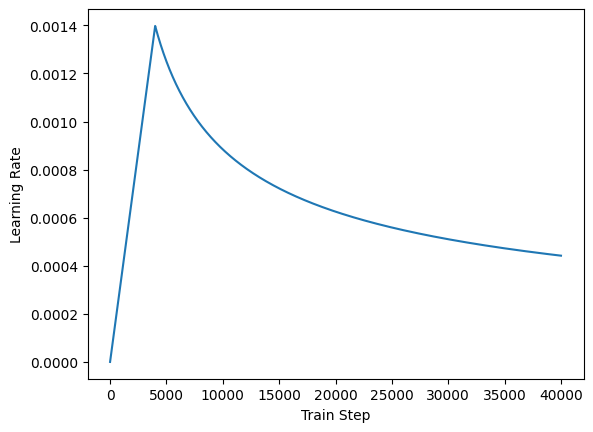

In [28]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

Next, we set up the loss. Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

We will use the sparse categorical cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`) and set the parameter `from_logits` to False since the Transformer does not output raw logits since the last layer has a softmax activation:

In [29]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

def masked_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


train_loss = tf.keras.metrics.Mean(name='train_loss')

# Here we will store the losses, so we can later plot them
losses = []

Now we can define our custom training function.

In [30]:
@tf.function
def train_step(model, inp, tar):
    """
    One training step for the transformer
    Arguments:
        inp (tf.Tensor): Input data to summarize
        tar (tf.Tensor): Target (summary)
    Returns:
        None
    """
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    # Create masks
    enc_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar_inp)[1])
    dec_padding_mask = create_padding_mask(inp) # Notice that both encoder and decoder padding masks are equal

    with tf.GradientTape() as tape:
        predictions, _ = model(
            inp,
            tar_inp,
            True,
            enc_padding_mask,
            look_ahead_mask,
            dec_padding_mask
        )
        loss = masked_loss(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

Now you are ready for training the model.


## 10 - Summarization

The last thing we will implement is inference. With this, we will be able to produce actual summaries of the documents. We will use a simple method called greedy decoding, which means we will predict one word at a time and append it to the output. We will start with an `[SOS]` token and repeat the word by word inference until the model returns us the `[EOS]` token or until we reach the maximum length of the sentence (we need to add this limit, otherwise a poorly trained model could give you infinite sentences without ever producing the `[EOS]` token.



In [31]:

def next_word(model, encoder_input, output):
    """
    Helper function for summarization that uses the model to predict just the next word.
    Arguments:
        encoder_input (tf.Tensor): Input data to summarize
        output (tf.Tensor): (incomplete) target (summary)
    Returns:
        predicted_id (tf.Tensor): The id of the predicted word
    """
    # Create a padding mask for the input (encoder)
    enc_padding_mask = create_padding_mask(encoder_input)
    # Create a look-ahead mask for the output
    look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])
    # Create a padding mask for the input (decoder)
    dec_padding_mask = create_padding_mask(encoder_input)

    # Run the prediction of the next word with the transformer model
    predictions, attention_weights = model(encoder_input, output, False,
                                           enc_padding_mask, look_ahead_mask, dec_padding_mask)

    # Select the last word predictions
    predictions = predictions[:, -1:, :]  # Get the predictions for the last token
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    return predicted_id

Check if the function works.

In [32]:
# Take a random sentence as an input
input_document = tokenizer.texts_to_sequences(["a random sentence"])
input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
encoder_input = tf.expand_dims(input_document[0], 0)

# Take the start of sentence token as the only token in the output to predict the next word
output = tf.expand_dims([tokenizer.word_index["[SOS]"]], 0)

# predict the next word with your function
predicted_token = next_word(transformer, encoder_input, output)
print(f"Predicted token: {predicted_token}")

predicted_word = tokenizer.sequences_to_texts(predicted_token.numpy())[0]
print(f"Predicted word: {predicted_word}")

Predicted token: [[30832]]
Predicted word: hahahaha😂😂😂😂😂😂😂


In [33]:
def summarize(model, input_document):
    """
    A function for summarization using the transformer model
    Arguments:
        input_document (tf.Tensor): Input data to summarize
    Returns:
        _ (str): The summary of the input_document
    """
    input_document = tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
    encoder_input = tf.expand_dims(input_document[0], 0)

    output = tf.expand_dims([tokenizer.word_index["[SOS]"]], 0)

    for i in range(decoder_maxlen):
        predicted_id = next_word(model, encoder_input, output)
        output = tf.concat([output, predicted_id], axis=-1)

        if predicted_id == tokenizer.word_index["[EOS]"]:
            break

    return tokenizer.sequences_to_texts(output.numpy())[0]  # since there is just one translated document

Now we can already summarize a sentence! But beware, since the model was not yet trained at all, it will just produce nonsense.

In [34]:
training_set_example = 0

# Check a summary of a document from the training set
print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
summarize(transformer, document[training_set_example])

Training set example:
[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:


"[SOS] hahahaha😂😂😂😂😂😂😂 recheck messing messing amanda bettina affected die amanda tomasz electoral pranksters time… hahhah 👍👍20th moaning taht coctails helicoptered wild' mock venezia 👱\u200d♀️ taht north north wrapped wrapped wrapped maybelline fluffly clarissa's developments developments developments developments offering developments tvs developments haemorrhoids maybelline 00pm spuds denon elary sorbonne carey's pressing sauté"


## 11 - Train the model

Now we can finally train the model. Below is a loop that will train our model for 25 epochs. note that it should take about 30 seconds per epoch (with the exception of the first few epochs which can take a few minutes each).

Note that after each epoch we perform the summarization on one of the sentences in the test set and print it out, so we can see how our model is improving.

In [35]:
# Take an example from the test set, to monitor it during training
test_example = 0
true_summary = summary_test[test_example]
true_document = document_test[test_example]

# Define the number of epochs
epochs = 25

# Training loop
for epoch in range(epochs):

    start = time.time()
    train_loss.reset_states()
    number_of_batches=len(list(enumerate(dataset)))

    for (batch, (inp, tar)) in enumerate(dataset):
        print(f'Epoch {epoch+1}, Batch {batch+1}/{number_of_batches}', end='\r')
        train_step(transformer, inp, tar)

    print (f'Epoch {epoch+1}, Loss {train_loss.result():.4f}')
    losses.append(train_loss.result())

    print (f'Time taken for one epoch: {time.time() - start} sec')
    print('Example summarization on the test set:')
    print('  True summarization:')
    print(f'    {true_summary}')
    print('  Predicted summarization:')
    print(f'    {summarize(transformer, true_document)}\n')

Epoch 1, Loss 7.8950
Time taken for one epoch: 63.40859389305115 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] [EOS]

Epoch 2, Loss 6.5900
Time taken for one epoch: 29.199660778045654 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] is going to the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Epoch 3, Loss 6.0242
Time taken for one epoch: 25.6218740940094 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
 

Plot the loss funtion.

Text(0.5, 0, 'Epoch')

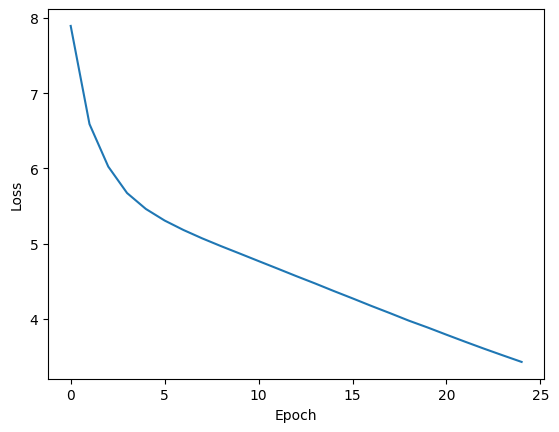

In [36]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')


## 12 - Summarize some Sentences!

Below we can see an example of summarization of a sentence from the training set and a sentence from the test set.

In [37]:
training_set_example = 0

# Check a summary of a document from the training set
print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
print(summarize(transformer, document[training_set_example]))

Training set example:
[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:
[SOS] amanda will bring some cookies tomorrow [EOS]


In [39]:
test_set_example = 4

# Check a summary of a document from the test set
print('Test set example:')
print(document_test[test_set_example])
print('\nHuman written summary:')
print(summary_test[test_set_example])
print('\nModel written summary:')
print(summarize(transformer, document_test[test_set_example]))

Test set example:
[SOS] ollie: hi , are you in warsaw  jane: yes, just back! btw are you free for diner the 19th?  ollie: nope!  jane: and the  18th?  ollie: nope, we have this party and you must be there, remember?  jane: oh right! i lost my calendar..  thanks for reminding me  ollie: we have lunch this week?  jane: with pleasure!  ollie: friday?  jane: ok  jane: what do you mean " we don't have any more whisky!" lol..  ollie: what!!!  jane: you just call me and the all thing i heard was that sentence about whisky... what's wrong with you?  ollie: oh oh... very strange! i have to be carefull may be there is some spy in my mobile! lol  jane: dont' worry, we'll check on friday.  ollie: don't forget to bring some sun with you  jane: i can't wait to be in morocco..  ollie: enjoy and see you friday  jane: sorry ollie, i'm very busy, i won't have time for lunch  tomorrow, but may be at 6pm after my courses?this trip to morocco was so nice, but time consuming!  ollie: ok for tea!  jane: i'm 